## アイデア
- 前処理を行う
  - [https://yrarchi.net/rectangle_detection_summary/](https://yrarchi.net/rectangle_detection_summary/)
- 
- cv2で矩形を切り出す
  - 手順ごとに塊として取り出せへん？
  - 文字に対して（というよりは画像全体に対して）膨張処理を行い，文字を潰して大きな四角形みたいにする
    - 取り出した矩形のうち，画像とかはいらないので，pytesseractで何文字以上検知できなければそれは画像だからその領域は無視するとかいう処理を挟む


- 画像部分を消したい

- 自然画像で行うのならホモグラフィー変換により文字が認識しやすくなるように変換できる

In [1]:
import pyocr
import cv2
import numpy as np
import pytesseract

import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

In [96]:
def plot_img(img, is_gray=False, figsize=(15, 20)):
    plt.figure(figsize=figsize)
    if is_gray:
        plt.imshow(img, cmap="gray")
    else:
        plt.imshow(img)
    plt.show()

def bgr2rgb(img_bgr):
    return cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

def binarize(img_rgb, th= 255 // 2):
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    _, img_bin = cv2.threshold(img_gray, th, 255, cv2.THRESH_BINARY)
    return img_bin

def binarize_otsu(img_rgb):
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    th, img_bin = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    print(f"binary threshold: {th}")
    return img_bin


def erode(img_bin, kernel_size=5, iterations=1):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    return cv2.erode(img_bin, kernel, iterations)

def find_contours(img):
    contours, _ = cv2.findContours(img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    # contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def approximate_contours(img, contours):
    """輪郭を条件で絞り込んで矩形のみにする
    """
    height, width, _ = img.shape
    img_size = height * width
    approx_contours = []
    for contour in contours:
        arclen = cv2.arcLength(contour, True)
        area = cv2.contourArea(contour)
        if arclen != 0 and img_size * 0.0001 < area < img_size * 0.9:
            approx_contour = cv2.approxPolyDP(contour, epsilon=0.03 * arclen, closed=True)
            if len(approx_contour) >= 4:
                approx_contours.append(approx_contour)
    return approx_contours

def approximate_convex(img, contours):
    """凸包で囲む"""
    height, width, _ = img.shape
    img_size = height * width
    approx_hulls = []
    for contour in contours:
        hull = cv2.convexHull(contour)
        if len(hull) >= 4 and img_size * 0.01 < cv2.contourArea(hull) < img_size * 0.8:
            approx_hulls.append(hull)
            # x, y, h, w = cv2.boundingRect(hull)
            # approx_hulls.append(np.array([[y, x], [y + h, x], [y + h, x + w], [y, x + w]]))
    return approx_hulls

def bounding_rect(img, contours):
    """長方形で囲む"""
    height, width, _ = img.shape
    img_size = height * width
    rects = []
    for contour in contours:
        x, y, h, w = cv2.boundingRect(contour)
        rect = np.array([[x, y], [x + w, y], [x + w, y + h], [x, y + h]])
        if img_size * 0.01 < cv2.contourArea(rect) < img_size * 0.8:
            rects.append(rect)
    return rects
    


def plot_contours(img, th=200):
    img_bin = binarize(img, th)
    contours = find_contours(img_bin)
    approx_contours = approximate_contours(img_bin, contours)
    # drawn_img = cv2.drawContours(img.copy(), approx_contours, -1, (0, 0, 255, 255), 100)
    plot_img(cv2.drawContours(img.copy(), approx_contours, -1, (0, 0, 255, 255), 2))
    plot_img(cv2.drawContours(img.copy(), contours, -1, (0, 0, 255, 255), 2))

In [3]:
# imgpath = Path("src/recipes/recipe1.png")
imgpath = Path("src/recipes/recipe2.png")
# img = Image.open(imgpath)
img_bgr = cv2.imread(str(imgpath))
img = bgr2rgb(img_bgr)
img_bin = binarize(img, th=230)

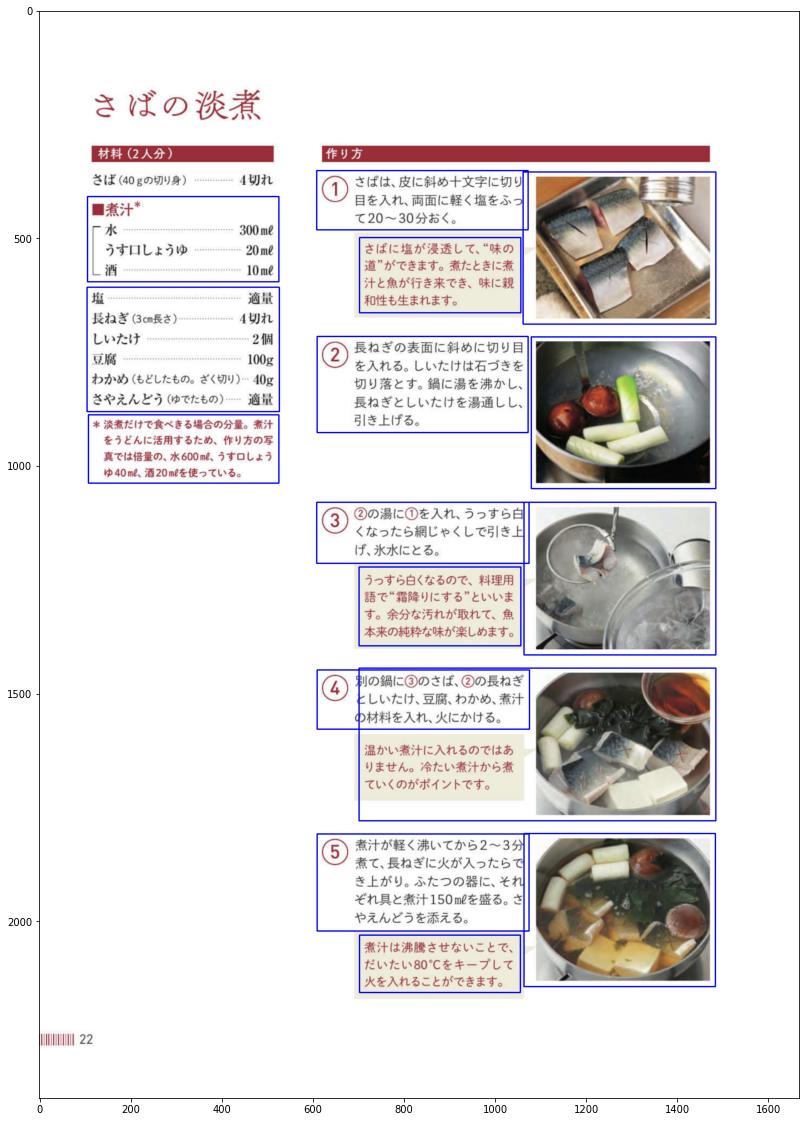

In [4]:
eroded_img = erode(img_bin, 20, 1)
contours = find_contours(eroded_img)

procedure_imgs = []

img_cp = img.copy()
img_h, img_w, _ = img_cp.shape
for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    if w > img_w * 0.05 and h > img_h * 0.05 and h * w < img_w * img_h * 0.1:
        cv2.rectangle(img_cp,(x, y), (x + w, y + h), (0, 0, 255, 255), 2)
        procedure_imgs.append(img[y : y + h, x : x + w, :])
        # plot_img(img[y : y + h, x : x + w, :])
plot_img(img_cp)

binary threshold: 177.0


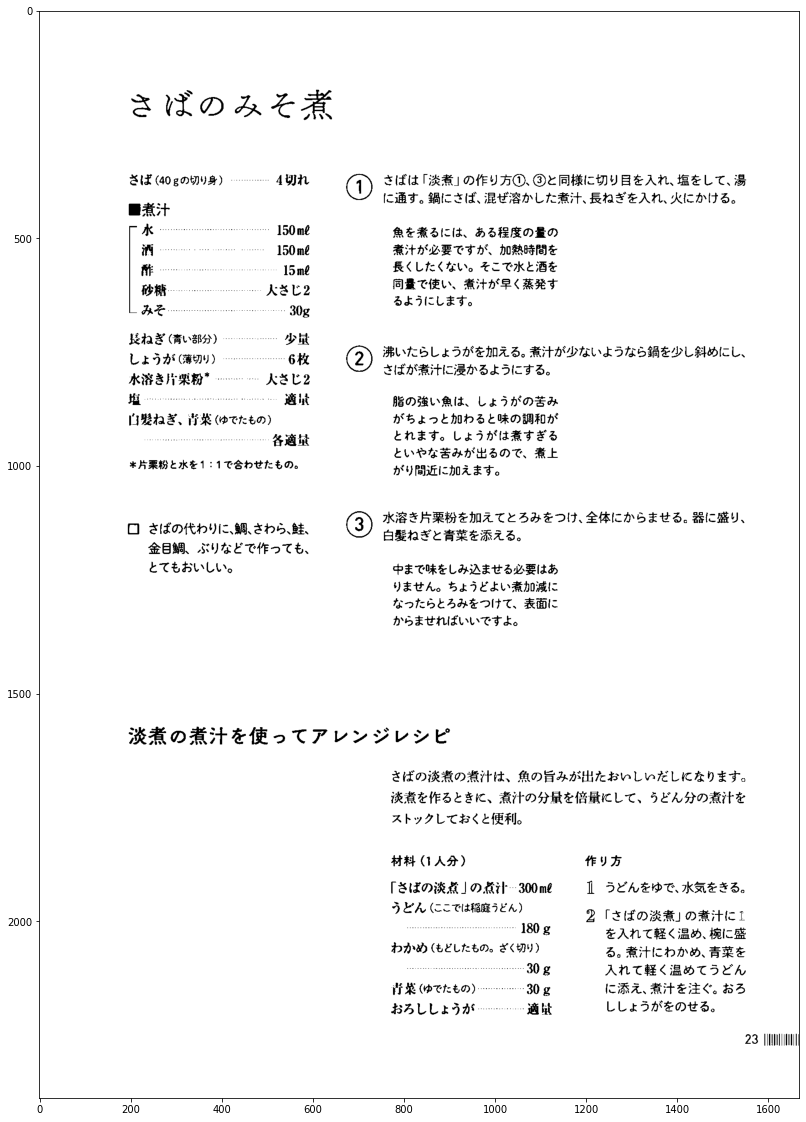

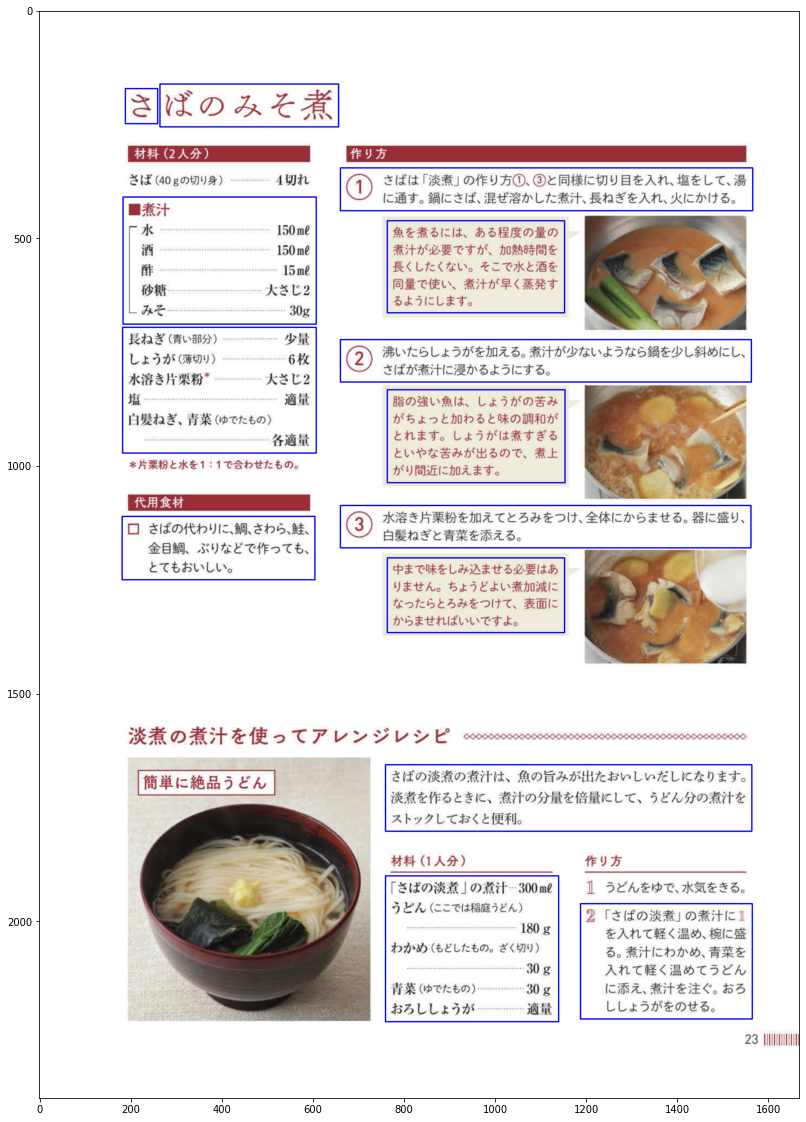

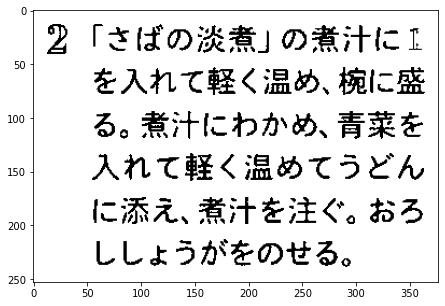

2「さばの淡煮」の煮汁にを入れて軽く温め、桃に盛る。煮汁にわかめ、青菜を入れて軽く温めてうどんに添え、煮汁を注ぐ。おろししょうがをのせる。


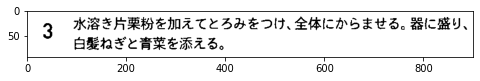

3水溶き片栗粉を加えてとろみをつけ、全体にからませる。器に盛り、白髪ねぎと青菜を添える。


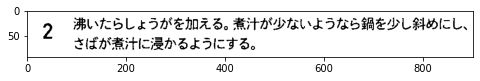

2沸いたらしょうがを加える。煮汁が少ないようなら鍋を少し斜めにし、さばが煮汁に浸かるようにする。


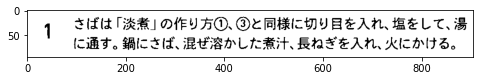

1さばは「淡煮」の作り方〇、③と同様に切り目を入れ、塩をして、湯に通す。鍋にさば、混ぜ溶かした煮汁、長ねぎを入れ、火にかける。
{2: '沸いたらしょうがを加える。煮汁が少ないようなら鍋を少し斜めにし、さばが煮汁に浸かるようにする。', 3: '水溶き片栗粉を加えてとろみをつけ、全体にからませる。器に盛り、白髪ねぎと青菜を添える。', 1: 'さばは「淡煮」の作り方〇、③と同様に切り目を入れ、塩をして、湯に通す。鍋にさば、混ぜ溶かした煮汁、長ねぎを入れ、火にかける。'}


In [134]:
imgpath = Path("src/recipes/recipe8.png")
# imgpath = Path("src/recipes/recipe4.png")
# imgpath = Path("src/recipes/recipe6.png")
# imgpath = Path("src/recipes/recipe2.png")
img_bgr = cv2.imread(str(imgpath))
img = bgr2rgb(img_bgr)
img_h, img_w, _ = img.shape
# img_bin = binarize(img, th=230)
img_bin = binarize_otsu(img)
contours = find_contours(img_bin)

# 画像全面を覆うほど大きくなく，ある程度の大きさを持つ矩形は，画像中の写真であるとして白塗りする
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if (w < img_w * 0.9 and h < img_h * 0.9) and (w > img_w * 0.1 or h > img_h * 0.1):
        img_bin[y : y + h, x : x + w] = 255
plot_img(img_bin, is_gray=True)

# eroded_img = erode(img_bin, 25, 1)
eroded_img = erode(img_bin, 26, 1)
contours = find_contours(eroded_img)

procedure_imgs = []

img_cp = img.copy()
for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    if w > img_w * 0.03 and h > img_h * 0.03 and h * w < img_w * img_h * 0.1:
        cv2.rectangle(img_cp,(x, y), (x + w, y + h), (0, 0, 255, 255), 2)
        procedure_imgs.append(img[y : y + h, x : x + w, :])
plot_img(img_cp)

tool = pyocr.get_available_tools()[0]
builder = pyocr.builders.TextBuilder(tesseract_layout=6)

procedures = {}

for procedure_img in procedure_imgs:
    procedure_bin = binarize(procedure_img, th=180)
    
    # 上半分・下半分・左半分・右半分で黒いピクセルが80%以上を占めるとき，それは主に画像である不要な領域なので排除する
    is_image_box = False
    h, w, _ = procedure_img.shape 
    for left, right, up, bottom in [[0, w, 0, h // 2], [0, w, h // 2, h], [0, w // 2, 0, h], [w // 2, w, 0, h]]:
        if cv2.countNonZero(procedure_bin[up : bottom, left : right]) < h * w * 0.2:
            is_image_box = True

    if not is_image_box:
        # dp:float  投票器の解像度．大きいほど検出基準が緩くなる
        # minDist:float  検出される円同士が最低限離れている距離
        # param1:float  内部で行われているCanny法によるエッジ検出の上限値
        # param2:float  円の中心を検出する際の閾値．低い値にすると誤検出が多くなる 
        # circles = cv2.HoughCircles(procedure_bin, cv2.HOUGH_GRADIENT, dp=0.1, minDist=100, param1=100, param2=30, minRadius=20, maxRadius=50)
        circles = cv2.HoughCircles(
            procedure_bin, 
            cv2.HOUGH_GRADIENT, 
            dp=0.1, 
            minDist=min(img_h, img_w) // 20, 
            param1=100, 
            param2=30, 
            minRadius=min(img_h, img_w) // 100, 
            maxRadius=min(img_h, img_w) // 50
        )
        if circles is not None:
            for circle in circles[0]:
                procedure_bin = cv2.circle(procedure_bin, (int(circle[0]), int(circle[1])), int(circle[2]), 255, min(img_h, img_w) // 150)

        text = tool.image_to_string(Image.fromarray(procedure_bin), lang="jpn", builder=builder)
        text = text.replace("\n", "").replace(" ", "")

        nums = [str(i) for i in range(10)]
        if len(text) > 5:
            if text[0] in nums:
                procedures[int(text[0])] = text[1:]
                plot_img(procedure_bin, is_gray=True, figsize=(8, 5))
                print(text)
            elif text[1] in nums:
                # 先頭の一文字目に余計なものが入っている場合のみ許容する
                # HACK: 正規表現を用いて実装可能
                procedures[int(text[1])] = text[2:]
                plot_img(procedure_bin, is_gray=True, figsize=(8, 5))
                print(text[1:])
print(procedures)

binary threshold: 177.0


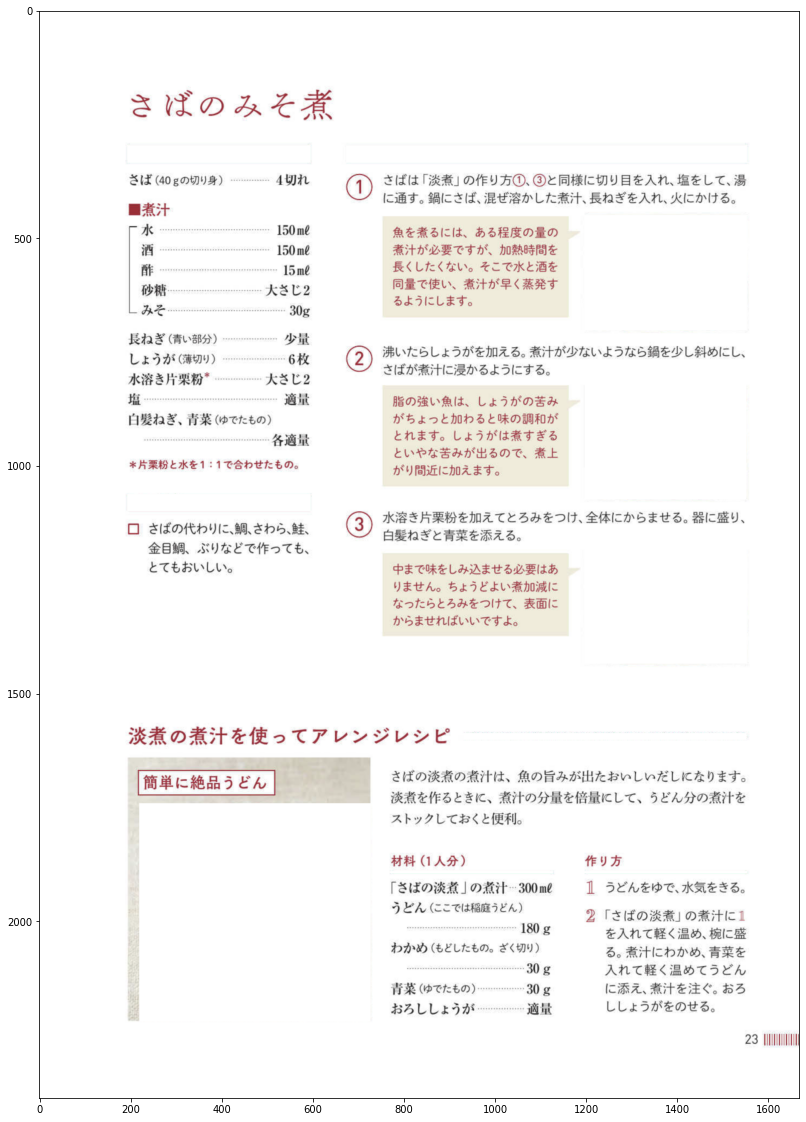

In [103]:
imgpath = Path("src/recipes/recipe7.png")
img_bgr = cv2.imread(str(imgpath))
img = bgr2rgb(img_bgr)
# img_bin = binarize(img, th=230)
img_bin = binarize_otsu(img)
contours = find_contours(img_bin)

img_cp = img.copy()
img_h, img_w, _ = img.shape
# 画像全面を覆うほど大きくなく，ある程度の大きさを持つ矩形は，画像中の写真であるとして白塗りする
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if (w < img_w * 0.9 and h < img_h * 0.9) and (w > img_w * 0.2 or h > img_h * 0.2):
        img_cp[y : y + h, x : x + w] = 255
plot_img(img_cp)

In [5]:
tool = pyocr.get_available_tools()[0]
text_builder = pyocr.builders.TextBuilder(tesseract_layout=6)
digit_builder = pyocr.builders.DigitBuilder(tesseract_layout=6)

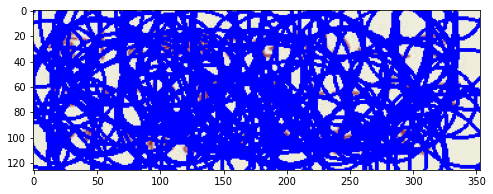

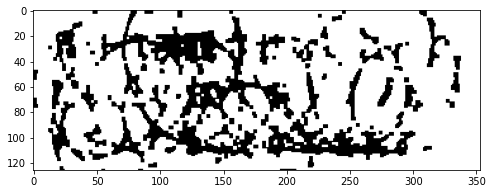


衝>キギにし誠:さ4ドいす生とNN7のトグルングーーてでンードー


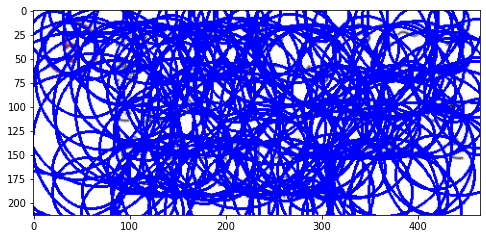

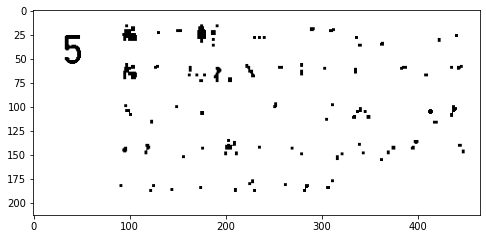

5
(⑤)煮汁が軽く沸いてから2ー3分煮て、長ねぎに火が入ったらでき上がり。ふたつの器に、それぞれ具と煮汁150m6を盛る。さやえんどうを添える。


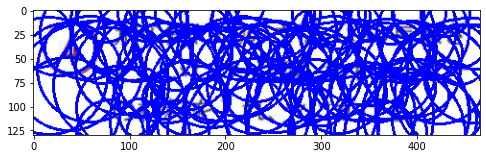

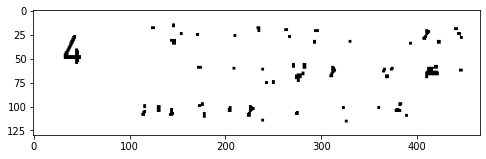

4 7.4
(の別の鍋に③のさば、②の長ねぎとしいたけ、豆腐、わかめ、煮汁の材料を入れ、火にかける。


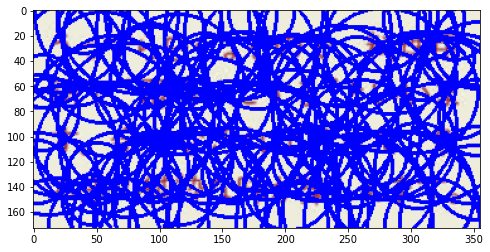

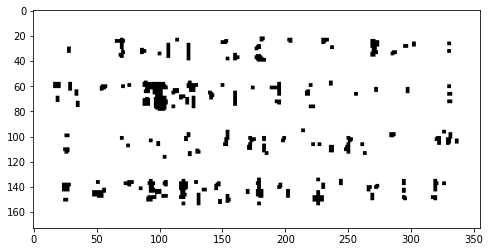


うっすら白くなるので、料理用語で“色降りにする"といいます。余分な汚れが取れて、人魚本来の純粋な味が楽しめます。


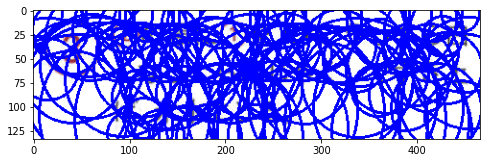

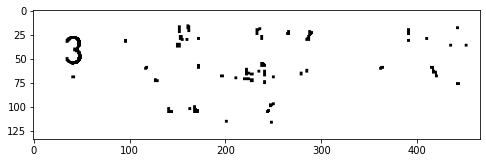

. 0
3 . . 1
.
(3)②の湯に①を入れ、うっすら白くなったら綱じゃくしで引き上げ、氷水にとる。


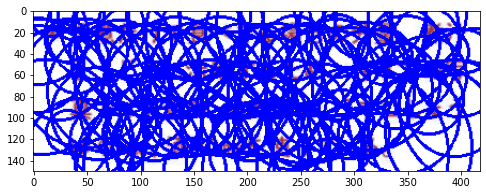

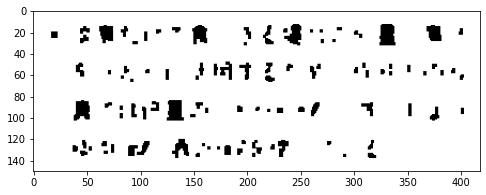


*淡煮だけで食べきる場合の分量。奏汁をうどんに活用するため、作り方の写真では倍量の、水600m@、うす品しょうゆ40m6、酒20m6を使っている。


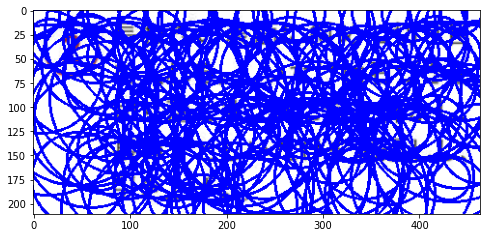

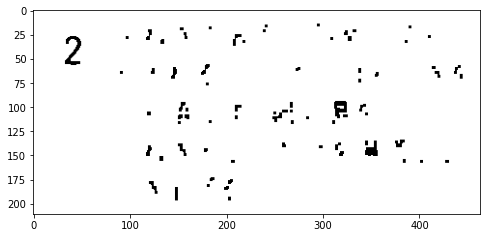

2 .
- .
-.
(2)長ねぎの表面に斜めに切り目を入れる。しいたけは石づきを切り落とす。鋼に湯を沸かし、長ねぎとしいたけを湯通しし、引き上げる。


KeyboardInterrupt: 

In [194]:
for procedure_img in procedure_imgs:
    procedure_bin_text = binarize(procedure_img, th= 180)
    is_image_box = False
    # 上半分・下半分・左半分・右半分で黒い部分が大半を占めるとき，それは主に画像である不要な領域なので排除する
    img_h, img_w, _ = procedure_img.shape 
    for left, right, up, bottom in [[0, img_w, 0, img_h // 2], [0, img_w, img_h // 2, img_h], [0, img_w // 2, 0, img_h], [img_w // 2, img_w, 0, img_h]]:
        if cv2.countNonZero(procedure_bin_text[up : bottom, left : right]) < img_h * img_w * 0.2:
            is_image_box = True

    if not is_image_box:
        # dp:float  投票器の解像度．大きいほど検出基準が緩くなる
        # minDist:float  検出される円同士が最低限離れている距離
        # param1:float  内部で行われているCanny法によるエッジ検出の上限値
        # param2:float  円の中心を検出する際の閾値．低い値にすると誤検出が多くなる 

        text = tool.image_to_string(Image.fromarray(procedure_bin_text), lang="jpn", builder=text_builder)
        text = text.replace("\n", "").replace(" ", "")

        if len(text) > 20:
            procedure_bin_digit = binarize(procedure_img, th=200)
            procedure_bin_digit = cv2.morphologyEx(procedure_bin_digit, cv2.MORPH_CLOSE, kernel=np.ones((4, 4),np.uint8))
            procedure_bin_digit = cv2.dilate(procedure_bin_digit, kernel=np.ones((2, 2), np.uint8), iterations=1)
            procedure_bin_digit = cv2.dilate(procedure_bin_digit, kernel=np.ones((1, 1), np.uint8), iterations=3)

            digits = tool.image_to_string(Image.fromarray(procedure_bin_digit), lang="eng", builder=digit_builder)

            circle_img = procedure_img.copy()
            for circle in circles[0]:
                circle_img = cv2.circle(circle_img, (int(circle[0]), int(circle[1])), int(circle[2]), (0, 0, 255), 2)
            plot_img(circle_img, figsize=(8, 5))
            plot_img(procedure_bin_digit, is_gray=True, figsize=(8, 5))
            print(digits)
            print(text)
        # if len(text) > 0 and text[0] == ".":
            # continue
        # text = text.replace(".", "")
        # if len(text) > 0:
            # print(text[0])

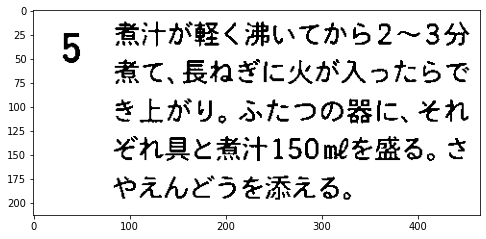

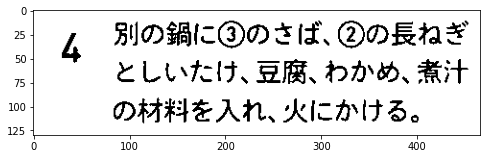

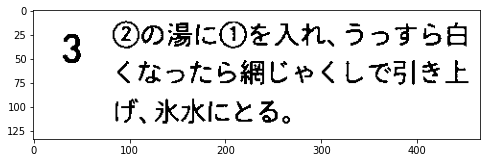

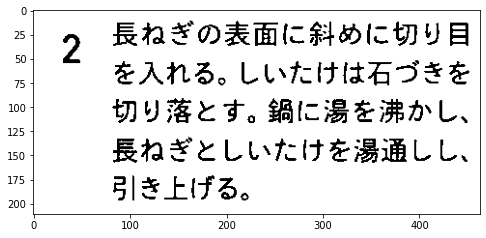

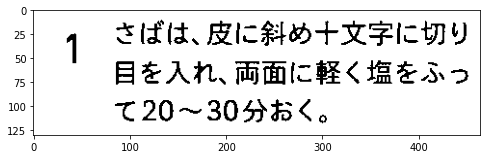

In [6]:
for procedure_img in procedure_imgs:
    procedure_bin_text = binarize(procedure_img, th= 180)
    is_image_box = False
    # 上半分・下半分・左半分・右半分で黒い部分が大半を占めるとき，それは主に画像である不要な領域なので排除する
    img_h, img_w, _ = procedure_img.shape 
    for left, right, up, bottom in [[0, img_w, 0, img_h // 2], [0, img_w, img_h // 2, img_h], [0, img_w // 2, 0, img_h], [img_w // 2, img_w, 0, img_h]]:
        if cv2.countNonZero(procedure_bin_text[up : bottom, left : right]) < img_h * img_w * 0.2:
            is_image_box = True

    if not is_image_box:
        # dp:float  投票器の解像度．大きいほど検出基準が緩くなる
        # minDist:float  検出される円同士が最低限離れている距離
        # param1:float  内部で行われているCanny法によるエッジ検出の上限値
        # param2:float  円の中心を検出する際の閾値．低い値にすると誤検出が多くなる 
        circles = cv2.HoughCircles(procedure_bin_text, cv2.HOUGH_GRADIENT, dp=0.1, minDist=100, param1=100, param2=30, minRadius=20, maxRadius=50)
        if circles is not None:
            circle_img = procedure_bin_text.copy()
            for circle in circles[0]:
                circle_img = cv2.circle(circle_img, (int(circle[0]), int(circle[1])), int(circle[2]), 255, 10)
            plot_img(circle_img, is_gray=True, figsize=(8, 5))

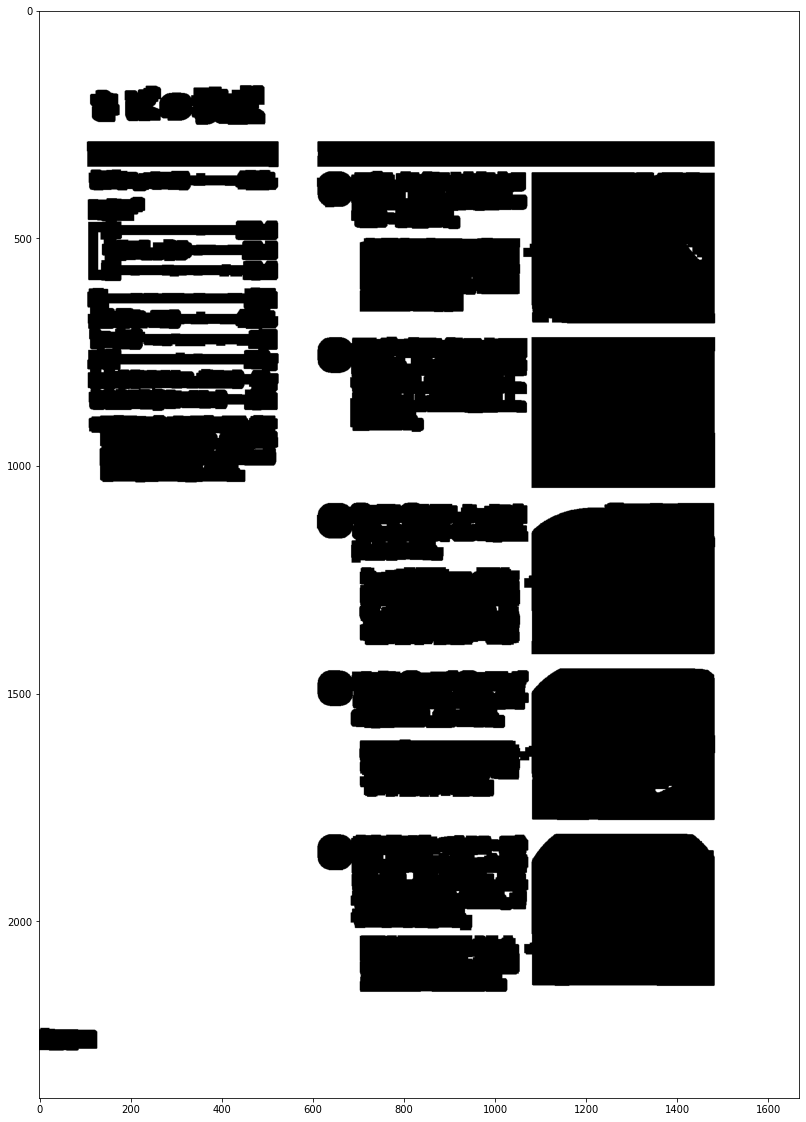

In [10]:
plot_img(erode(binarize(img, th=230), kernel_size=20), is_gray=True)

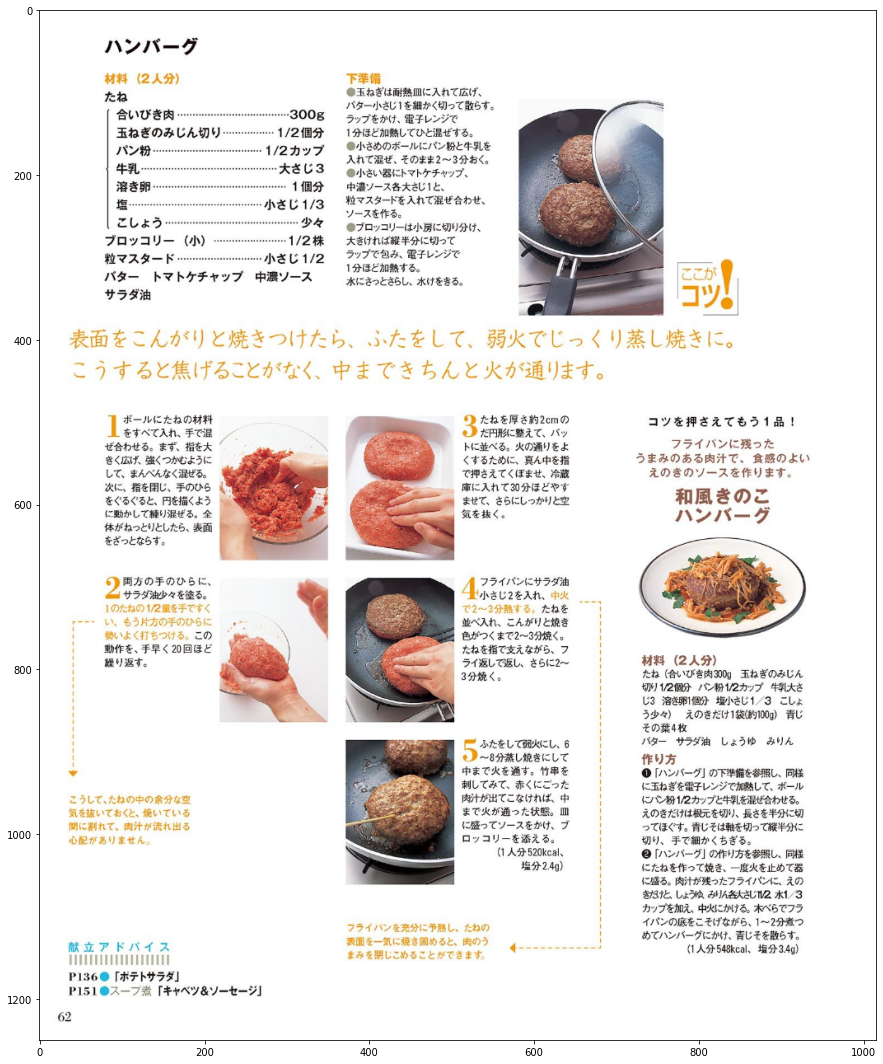

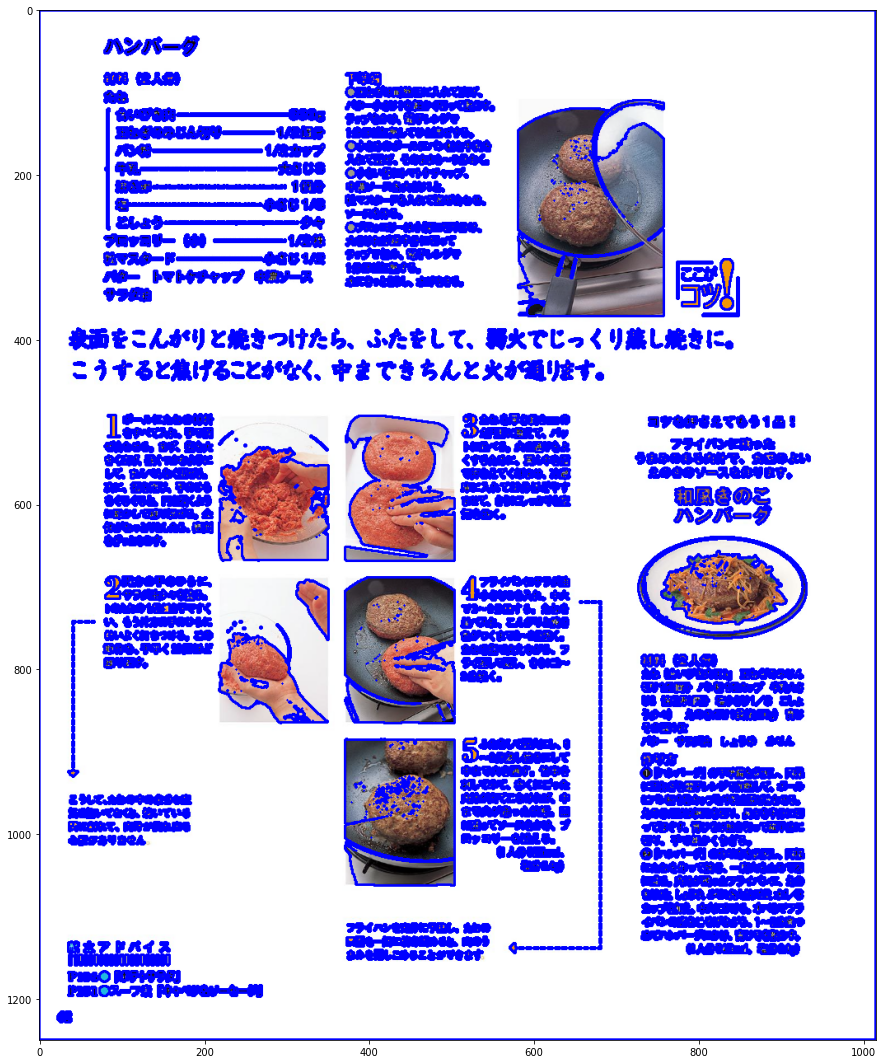

In [5]:
plot_contours(img)

In [114]:
# pyocr
tool = pyocr.get_available_tools()[0]
builder = pyocr.builders.TextBuilder(tesseract_layout=6)

In [43]:
text = tool.image_to_string(img, lang="jpn", builder=builder)

In [44]:
print(text)

ハン バー グ
材料 (2 人 分 ) 下 準備
た ね トー の ーー
パタ ー 小 さじ 1 を 細か く 切 っ て 散ら す 。 き
合い びき 肉 ヘ ーー300g ラッ フ を か 0、 電 テレ ンジ
玉ねぎ の みじん 切り ………… 172 個 分 1 分 ほど 加熱 し て ひと 混ぜ する 。
MM ッ @ 小 さめ の ボー ル に パン 接 と 和牛 乳 を に
バン 維 172 カ ッ プ て g、 の まま 2 お <
さる 3 3
溶き 卵 …………mmmmmmmmmmm 1 個 分 中 湯 ソ ー ス 各 大 きじ 1 と 、
ーー か きせ 粒 マ スタ ー ド を 入れ て 混ぜ 合わ せ 、
テー の .
0 ーーー
ブロ ッ コ リー ( 小 ) ーー172 株 ーー テー ビジ N
ーー ドーガ 日 ラッ プ で 包み 、 電子 レン ジ で
粒 マ スタ ー ド さる が に
パタ ー トマ ト ケ チ ャ ッ プ 中 濃 ソ ー ス 水 に さっ と さら し 、 水 け を きる 。 に
サラ タダ タ 油 に 。 コグ 4|
ー ヾ > 、 に で る
表面 を こん が り と 焼き つけ た ら 、 ふ た を し て 、 弱 火 で じっくり 蒸し 焼き に 。
こう する と 焦げ る こと が な く 、 中 まで きち ん と 火 が 通り ます 。
1 トラ ce ビビ ーー ペー コツ を 押さ えて も う 1 品 !
を すべ て 入れ 、 手 で 混 本 玉 に 団 え て 、 バッ ー
ぜ 合 わせ る 。 ま ず 、 指 を 大 ト に 並べ る 。 火 の 通り を よ フラ イ バ ン に 残っ た
きく 応 強く つか むように くす る た め に 、 真ん中 を 者 うま み の あ る 肉汁 で 、 食 感 の よい
し て 、 まん ぺん な く 湿 ば る 。 で 押さ えて く ぽ ませ 、 冷 基 えのき の ソー ス を 作り ます 。
次 に 、 指 を 閉じ 、 手 の ひら 庫 に 入れ て 30 分 ほど や す
を くぐる ぐる と 、 円 を 描く よう に ッ ませ て 、 さ ら に し っ か り と 空 和風 きのこ
に 動か し て 線 り 混 